In [1]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import evaluation

INFO summa.preprocessing.cleaner: 'pattern' package not found; tag filters are not available for English


## Preprocessing

#### Liste mit Dateinamen erzeugen

In [2]:
path_txt = "corpus_txt"
#path_txt = "grenzbote_plain/*/"
#path_txt = "wiki/"

doclist_txt = pre.create_document_list(path_txt)
assert doclist_txt, "No documents found"
doclist_txt[:5]

INFO preprocessing: Creating document list from TXT files ...


['corpus_txt/Lovecraft_AttheMountainofMadness.txt',
 'corpus_txt/Howard_TheDevilinIron.txt',
 'corpus_txt/Poe_ThePurloinedLetter.txt',
 'corpus_txt/Lovecraft_TheShunnedHouse.txt',
 'corpus_txt/Poe_TheMasqueoftheRedDeath.txt']

#####  Liste mit Dokumentenlabels erzeugen - (Funktion wird durch Thorsten's generischere Funktion ersetzt)

In [3]:
doc_labels = list(pre.get_labels(doclist_txt))
doc_labels[:5]

INFO preprocessing: Creating document labels ...


['Lovecraft_AttheMountainofMadness',
 'Howard_TheDevilinIron',
 'Poe_ThePurloinedLetter',
 'Lovecraft_TheShunnedHouse',
 'Poe_TheMasqueoftheRedDeath']

#### Corpus laden

In [4]:
corpus_txt = pre.read_from_txt(doclist_txt)

#### Tokenisieren

In [5]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]

INFO preprocessing: Accessing TXT documents ...


#### Create Dictionaries

In [6]:
id_types = pre.create_dictionary(doc_tokens)
doc_ids = pre.create_dictionary(doc_labels)

#### Sparse BOW Model

In [7]:
sparse_bow = pre.create_sparse_bow(doc_labels, doc_tokens, id_types, doc_ids)

In [8]:
sparse_bow[:5]

0
doc_id token_id   
1      8198      1
       7         2
       8         1
       8202      1
       16395     1

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [9]:
pre.save_sparse_bow(sparse_bow, "gensim_txt")

#### Import Market Matrix

In [10]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus
from gensim.corpora import SvmLightCorpus

In [11]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 369906 non-zero entries


In [12]:
corpus = MmCorpus('gensim_txt.mm')
SvmLightCorpus.serialize('corpus.svmlight', corpus)

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 369906 non-zero entries
INFO gensim.corpora.svmlightcorpus: converting corpus to SVMlight format: corpus.svmlight
INFO gensim.corpora.indexedcorpus: saving SvmLightCorpus index to corpus.svmlight.index


In [13]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

##### Remove Features

type2id = {value : key for key, value in id_types.items()}
sparse_bow_collapsed = sparse_bow.groupby(sparse_bow.index.get_level_values('token_id')).sum()

sparse_bow_hapax = sparse_bow_collapsed.loc[sparse_bow_collapsed[0] == 1]
hapax = [type2id[key] for key in sparse_bow_hapax.index.get_level_values('token_id')]

len(hapax)

In [14]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "de.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

In [15]:
hapax_from_remove = pre.find_hapax(sparse_bow, id_types)
stopwords_from_remove = pre.find_stopwords(sparse_bow, id_types, mfw=75)

#features_to_be_removed = set(hapax_from_remove + stopwords_from_remove)
features_to_be_removed = stopwords_from_remove

sparse_bow_short = pre.remove_features(sparse_bow, id_types, features_to_be_removed)

INFO preprocessing: Finding hapax legomena ...
INFO preprocessing: Finding stopwords ...
INFO preprocessing: Removing features ...


In [16]:
len(features_to_be_removed)

75

In [17]:
pre.save_sparse_bow(sparse_bow_short, "gensim_txt")

In [18]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 369906 non-zero entries


#### Convert sparse_bow to list of (doc, tokens) tuples (like doc2bow)

In [19]:
doc2bow_list = []

for doc in sparse_bow_short.index.groupby(sparse_bow_short.index.get_level_values('doc_id')):
    temp = [(token, count) for token, count in zip(sparse_bow_short.loc[doc].index, sparse_bow_short.loc[doc][0])]
    doc2bow_list.append(temp)

In [20]:
len(doc2bow_list)

17

In [21]:
model = LdaModel(corpus=mm, id2word=type2id, num_topics=20, passes = 10, iterations = 20)

INFO gensim.models.ldamodel: using symmetric alpha at 0.05
INFO gensim.models.ldamodel: using symmetric eta at 4.49781855799937e-05
INFO gensim.models.ldamodel: using serial LDA version on this node
INFO gensim.models.ldamodel: running online LDA training, 20 topics, 10 passes over the supplied corpus of 17 documents, updating model once every 17 documents, evaluating perplexity every 17 documents, iterating 20x with a convergence threshold of 0.001000
INFO gensim.models.ldamodel: -12.542 per-word bound, 5961.7 perplexity estimate based on a held-out corpus of 17 documents with 369906 words
INFO gensim.models.ldamodel: PROGRESS: pass 0, at document #17/17
INFO gensim.models.ldamodel: topic #18 (0.050): 0.058*"decidedly" + 0.031*"appertain" + 0.031*"invaluable" + 0.025*"cease" + 0.015*"grovelling" + 0.011*"namelessly" + 0.011*"vowed" + 0.010*"flickered" + 0.010*"village-alive" + 0.010*"outwitted"
INFO gensim.models.ldamodel: topic #0 (0.050): 0.066*"decidedly" + 0.032*"appertain" + 0.02

In [22]:
model.get_document_topics(doc2bow_list[1])

[(5, 0.48155632419791006),
 (7, 0.015074485821617953),
 (9, 0.14674192638340758),
 (10, 0.19320042554799227),
 (11, 0.15558887034794608)]

In [23]:
#Anzeige der keywords für topic n
n = 1
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['decidedly',
 'appertain',
 'invaluable',
 'cease',
 'vowed',
 'grovelling',
 'vine-shaded',
 'flickered',
 'village-alive',
 'namelessly']

In [24]:
#Topic probabilities - zum Testen der Funktion
topics = model.show_topics(num_topics = model.num_topics, formatted=False)
keywords = []

num_topics = model.num_topics
topics_df = pre.pd.DataFrame(index = range(num_topics), columns= range(10))

for topic, values in topics:
    keyword = [value[0] for value in values]
    topics_df.loc[topic] = keyword

topics_df

,0,1,2,3,4,5,6,7,8,9
0,decidedly,appertain,cease,invaluable,namelessly,vine-shaded,vowed,grovelling,ascended,robert
1,decidedly,appertain,invaluable,cease,vowed,grovelling,vine-shaded,flickered,village-alive,namelessly
2,decidedly,cease,appertain,invaluable,grovelling,namelessly,vine-shaded,friendship,flickered,vowed
3,decidedly,invaluable,appertain,cease,grovelling,vowed,mantel-piece,namelessly,village-alive,vine-shaded
4,decidedly,invaluable,appertain,grovelling,cease,vowed,namelessly,village-alive,mantel-piece,vine-shaded
5,decidedly,invaluable,cease,appertain,grovelling,namelessly,village-alive,ascended,outwitted,smoothed
6,decidedly,invaluable,appertain,cease,grovelling,namelessly,vine-shaded,vowed,flickered,ascended
7,decidedly,appertain,invaluable,cease,your-eye,tar-like,grovelling,vine-shaded,person,exhibitions
8,decidedly,invaluable,appertain,cease,grovelling,vowed,village-alive,namelessly,vine-shaded,flickered
9,decidedly,invaluable,appertain,cease,grovelling,friendship,robert,vine-shaded,namelessly,outwitted


In [25]:
topics_df = pre.gensim2dataframe(model)
topics_df

,0,1,2,3,4,5,6,7,8,9
0,decidedly,appertain,cease,invaluable,namelessly,vine-shaded,vowed,grovelling,ascended,robert
1,decidedly,appertain,invaluable,cease,vowed,grovelling,vine-shaded,flickered,village-alive,namelessly
2,decidedly,cease,appertain,invaluable,grovelling,namelessly,vine-shaded,friendship,flickered,vowed
3,decidedly,invaluable,appertain,cease,grovelling,vowed,mantel-piece,namelessly,village-alive,vine-shaded
4,decidedly,invaluable,appertain,grovelling,cease,vowed,namelessly,village-alive,mantel-piece,vine-shaded
5,decidedly,invaluable,cease,appertain,grovelling,namelessly,village-alive,ascended,outwitted,smoothed
6,decidedly,invaluable,appertain,cease,grovelling,namelessly,vine-shaded,vowed,flickered,ascended
7,decidedly,appertain,invaluable,cease,your-eye,tar-like,grovelling,vine-shaded,person,exhibitions
8,decidedly,invaluable,appertain,cease,grovelling,vowed,village-alive,namelessly,vine-shaded,flickered
9,decidedly,invaluable,appertain,cease,grovelling,friendship,robert,vine-shaded,namelessly,outwitted


In [26]:
doc_topic = topics_df.T
doc_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,decidedly,decidedly,decidedly,decidedly,decidedly,decidedly,decidedly,decidedly,decidedly,decidedly,decidedly,decidedly,appertain,decidedly,decidedly,decidedly,decidedly,decidedly,decidedly,decidedly
1,appertain,appertain,cease,invaluable,invaluable,invaluable,invaluable,appertain,invaluable,invaluable,appertain,appertain,vowed,appertain,appertain,invaluable,invaluable,appertain,invaluable,appertain
2,cease,invaluable,appertain,appertain,appertain,cease,appertain,invaluable,appertain,appertain,invaluable,cease,refracted,invaluable,invaluable,appertain,appertain,invaluable,appertain,invaluable
3,invaluable,cease,invaluable,cease,grovelling,appertain,cease,cease,cease,cease,cease,invaluable,decidedly,cease,cease,cease,cease,cease,cease,cease
4,namelessly,vowed,grovelling,grovelling,cease,grovelling,grovelling,your-eye,grovelling,grovelling,vowed,vowed,vine-shaded,grovelling,namelessly,grovelling,vowed,grovelling,grovelling,vowed
5,vine-shaded,grovelling,namelessly,vowed,vowed,namelessly,namelessly,tar-like,vowed,friendship,flickered,flickered,cease,village-alive,vowed,vowed,grovelling,namelessly,namelessly,grovelling
6,vowed,vine-shaded,vine-shaded,mantel-piece,namelessly,village-alive,vine-shaded,grovelling,village-alive,robert,namelessly,grovelling,meshes,namelessly,grovelling,village-alive,vine-shaded,vine-shaded,outwitted,namelessly
7,grovelling,flickered,friendship,namelessly,village-alive,ascended,vowed,vine-shaded,namelessly,vine-shaded,grovelling,namelessly,sit-up,friendship,flickered,vine-shaded,namelessly,vowed,vowed,village-alive
8,ascended,village-alive,flickered,village-alive,mantel-piece,outwitted,flickered,person,vine-shaded,namelessly,vine-shaded,vine-shaded,penguin,vowed,vine-shaded,namelessly,village-alive,ascended,village-alive,vine-shaded
9,robert,namelessly,vowed,vine-shaded,vine-shaded,smoothed,ascended,exhibitions,flickered,outwitted,village-alive,ben-sheep,invaluable,vine-shaded,friendship,friendship,flickered,flickered,vine-shaded,refracted


## Visualisierung 

In [27]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

"lda_model = 'out_easy/corpus.lda'\ncorpus = 'out_easy/corpus.mm'\ndictionary = 'out_easy/corpus.dict'\ndoc_labels = 'out_easy/corpus_doclabels.txt'\ninteractive  = False\n\nvis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)"

##### Create a document-topic matrix (that is a pandas data frame actually)

In [28]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

<module 'matplotlib.pyplot' from '/home/sina/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

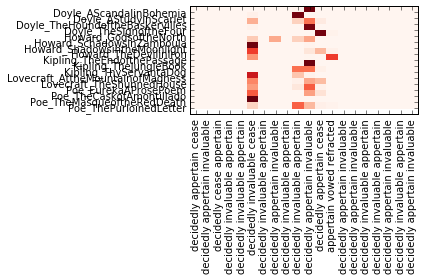

In [29]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

<module 'matplotlib.pyplot' from '/home/sina/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

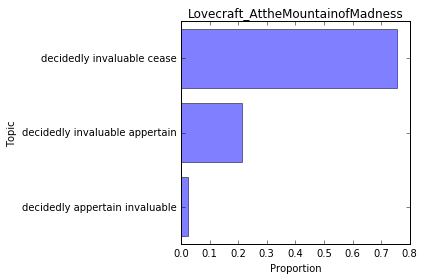

In [30]:
visual.plot_doc_topics(doc_topic, 0)

In [31]:
items = model.show_topic(1)
keywords = [item[0] for item in items]
keywords
items = model.show_topic(1)
propabilities = [item[1] for item in items]
propabilities
items

[('decidedly', 0.0082714017814873881),
 ('appertain', 0.0042683514741966334),
 ('invaluable', 0.0031566492745889042),
 ('cease', 0.0030601959371338106),
 ('vowed', 0.0020525735788667933),
 ('grovelling', 0.001966584166650413),
 ('vine-shaded', 0.0018564894853656821),
 ('flickered', 0.0016438404492069684),
 ('village-alive', 0.0016250602644918911),
 ('namelessly', 0.001421754146588437)]

<module 'matplotlib.pyplot' from '/home/sina/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

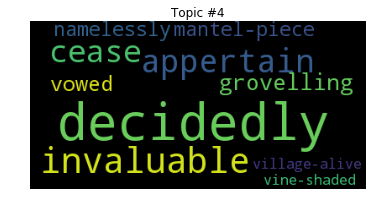

In [37]:
topic_nr = 3
number_of_keywords = 10
visual.show_wordle_for_topic(model, topic_nr, number_of_keywords)

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)